In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import getpass
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the database connection details
_data = np.load('data/db_details.npy', allow_pickle=True).tolist()
db_details = _data['db_details']
user = db_details['user']
host = db_details['host']
port = db_details['port']
dbname = db_details['dbname']
schema = db_details['schema']
    
# Connect to the database
conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, password=getpass.getpass(prompt='Password:'.format(user)))
cur = conn.cursor()
cur.execute('SET search_path TO {}'.format(schema))
conn.commit()

Password: ··········


In [3]:
# Select data for all ICU admissions
query = \
"""
SELECT
    i.subject_id,
    i.hadm_id,
    i.icustay_id,
    p.gender,
    p.dob,
    ROUND((CAST(a.admittime AS date) - CAST(p.dob AS date))/365.242,2) AS age,
    a.admittime,
    a.dischtime,
    i.intime,
    i.outtime,
    i.los,
    a.diagnosis,
    a.hospital_expire_flag
FROM
    icustays i
    INNER JOIN patients p ON i.subject_id = p.subject_id
    INNER JOIN admissions a ON p.subject_id = a.subject_id
"""

# Execute the query and fetch the result
cur = conn.cursor()
cur.execute(query)
conn.commit()
data = cur.fetchall()

# Store the result of the query as a pandas dataframe
labels = ['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dob', 'age', 'admittime', 'dischtime', 'intime', 'outtime', 'icu_los', 'diagnosis', 'hosp_expire_flag']
icu = pd.DataFrame(data, columns=labels)

In [4]:
# Show some sample data
icu.head()

,subject_id,hadm_id,icustay_id,gender,dob,age,admittime,dischtime,intime,outtime,icu_los,diagnosis,hosp_expire_flag
0,2,163353,243653,M,2138-07-17,0.00,2138-07-17 19:04:00,2138-07-21 15:48:00,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918,NEWBORN,0
1,3,145834,211552,M,2025-04-11,76.52,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,HYPOTENSION,0
2,4,185777,294638,F,2143-05-12,47.84,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0
3,5,178980,214757,M,2103-02-02,0.00,2103-02-02 04:31:00,2103-02-04 12:15:00,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844,NEWBORN,0
4,6,107064,228232,F,2109-06-21,65.94,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,CHRONIC RENAL FAILURE/SDA,0


In [5]:
# Print some statistics about the patient population
icu.head()
print('No. of patients: {}'.format(len(np.unique(icu['subject_id']))))
print('No. of distinct hospital stays: {}'.format(len(np.unique(icu['hadm_id']))))
print('No. of distinct ICU admissions: {}'.format(len(np.unique(icu['icustay_id']))))

No. of patients: 46476
No. of distinct hospital stays: 57786
No. of distinct ICU admissions: 61532


In [6]:
# Remove any patients under 16 years old
adult_icu = icu[icu['age']>=18]
print('Removed {} patients under 16 years old ({} ICU stays remaining)'.format(len(icu)-len(adult_icu), len(adult_icu)))

# Remove any patients with ICU stays under 24 hours
adult_48h_icu = adult_icu[adult_icu['icu_los']>=2]
print('Removed {} ICU stays that lasted less than 48 hours ({} ICU stays remaining)'.format(len(adult_icu)-len(adult_48h_icu), len(adult_48h_icu)))

# Select first ICU admission for each patient
icu_sorted = adult_48h_icu.sort_values(by=['subject_id', 'intime']) # sort patients by subject ID and ICU admission time
adult_48h_first_icu = icu_sorted.groupby('subject_id', as_index=False).first() # take the first ICU admission for each subject
print("Removed {} ICU admissions that were not the patient's first ICU admission ({} ICU stays remaining)".format(len(adult_48h_icu)-len(adult_48h_first_icu), len(adult_48h_first_icu)))

Removed 8583 patients under 16 years old (107843 ICU stays remaining)
Removed 48277 ICU stays that lasted less than 48 hours (59566 ICU stays remaining)
Removed 37045 ICU admissions that were not the patient's first ICU admission (22521 ICU stays remaining)


In [7]:
# Show some sample data for adult first ICU admission
adult_48h_first_icu.head()

,subject_id,hadm_id,icustay_id,gender,dob,age,admittime,dischtime,intime,outtime,icu_los,diagnosis,hosp_expire_flag
0,3,145834,211552,M,2025-04-11,76.52,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,HYPOTENSION,0
1,6,107064,228232,F,2109-06-21,65.94,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,CHRONIC RENAL FAILURE/SDA,0
2,9,150750,220597,M,2108-01-26,41.79,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231,HEMORRHAGIC CVA,1
3,12,112213,232669,M,2032-03-24,72.37,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-08 02:08:17,2104-08-15 17:22:25,7.6348,PANCREATIC CANCER/SDA,1
4,13,143045,263738,F,2127-02-27,39.86,2167-01-08 18:43:00,2167-01-15 15:15:00,2167-01-08 18:44:25,2167-01-12 10:43:31,3.6660,CORONARY ARTERY DISEASE,0


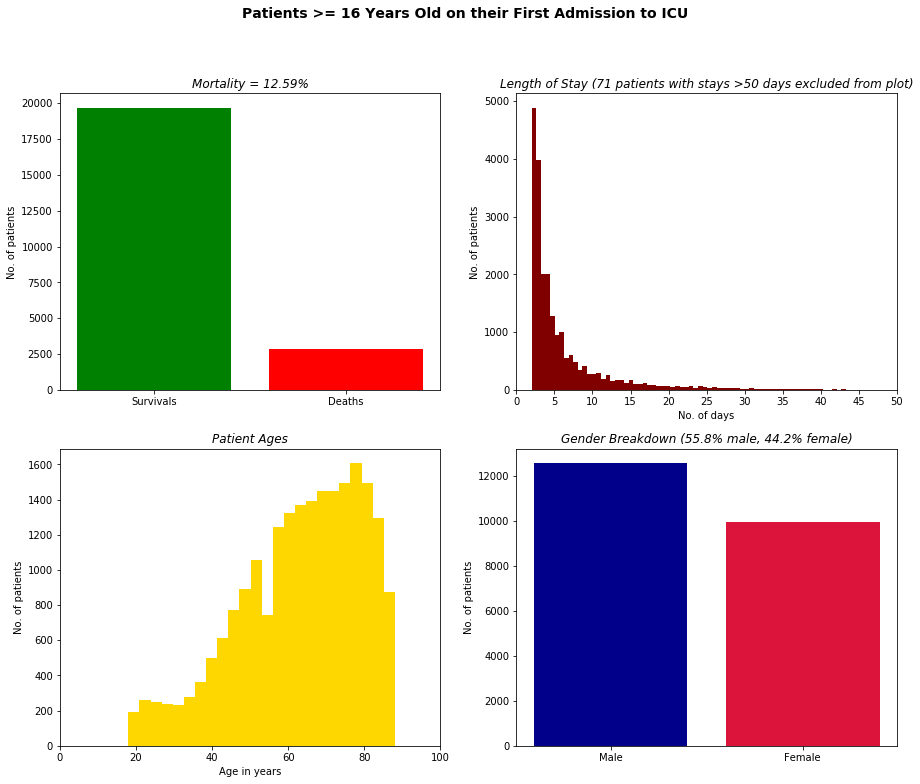

In [8]:
# Visualise mortality rate,length of ICU stay, age and gender
fig, axs = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle('Patients >= 16 Years Old on their First Admission to ICU', weight='semibold', fontsize=14)

# Plot the mortality
axs[0,0].bar(x=['Survivals','Deaths'], height=[len(adult_48h_first_icu)-sum(adult_48h_first_icu['hosp_expire_flag']),sum(adult_48h_first_icu['hosp_expire_flag'])], color=['g','r'])
axs[0,0].set_title('Mortality = {:.2f}%'.format(100*sum(adult_48h_first_icu['hosp_expire_flag'])/len(adult_48h_first_icu)), style='italic')
axs[0,0].set_ylabel('No. of patients')

# Plot the length of stay
axs[0,1].hist(x=adult_48h_first_icu['icu_los'], bins=250, color='maroon')
axs[0,1].set_title('Length of Stay (71 patients with stays >50 days excluded from plot)', style='italic')
axs[0,1].set_xlim([0,50])
axs[0,1].set_xticks(range(0,51,5))
axs[0,1].set_xlabel('No. of days')
axs[0,1].set_ylabel('No. of patients')

# Plot the patient ages
axs[1,0].hist(x=adult_48h_first_icu['age'].astype('int64'), bins=100, color='gold')
axs[1,0].set_title('Patient Ages', style='italic')
axs[1,0].set_xlim([0,100])
axs[1,0].set_xlabel('Age in years')
axs[1,0].set_ylabel('No. of patients')

# Plot the gender breakdown
axs[1,1].bar(x=['Male','Female'], height=[sum(adult_48h_first_icu['gender']=='M'),sum(adult_48h_first_icu['gender']=='F')], color=['darkblue','crimson'])
axs[1,1].set_title('Gender Breakdown ({:.1f}% male, {:.1f}% female)'.format(100*sum(adult_48h_first_icu['gender']=='M')/len(adult_48h_first_icu), 100*sum(adult_48h_first_icu['gender']=='F')/len(adult_48h_first_icu)), style='italic')
axs[1,1].set_ylabel('No. of patients');

In [9]:
# Sort patients by subject_id, then hadm_id and icustay_id if needed
adult_48h_first_icu.sort_values(by=['subject_id', 'hadm_id', 'icustay_id'])

# Save to yang_patients.npy
if not os.path.exists('./data'):
    os.makedirs('./data')

tosave = {'yang_patients': adult_48h_first_icu}
np.save('data/yang_patients.npy',tosave)
print("Saved!")

Saved!


In [10]:
len(adult_48h_first_icu)

22521